In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import random
import tensorflow.keras.utils as utils
import pydot
from tensorflow.keras import regularizers

In [3]:
import random
def create_rand_list(max_val, count):
    randomlist = random.sample(range(0, max_val + 1), count)
    return randomlist
create_rand_list(5,4)

[3, 5, 4, 0]

In [4]:
dataset_dir = "Datasets/energydata_use.csv"

In [5]:
df = pd.read_csv(dataset_dir, index_col=0)
df = df.fillna(df.mean())
df.head(10)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000
2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000
2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000
2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000
2016-01-11 17:50:00,50,40,19.890000,46.026667,19.20,44.500000,19.79,44.933333,18.890000,45.730000,...,18.1,48.590000,17.000000,45.29,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000
2016-01-11 18:00:00,60,50,19.890000,45.766667,19.20,44.500000,19.79,44.900000,18.890000,45.790000,...,18.1,48.590000,17.000000,45.29,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000
2016-01-11 18:10:00,60,50,19.856667,45.560000,19.20,44.500000,19.73,44.900000,18.890000,45.863333,...,18.1,48.590000,17.000000,45.29,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333
2016-01-11 18:20:00,60,40,19.790000,45.597500,19.20,44.433333,19.73,44.790000,18.890000,45.790000,...,18.1,48.590000,17.000000,45.29,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667


In [6]:
df.isnull().values.any()

False

In [9]:
def transform_dataset(df, group_num):
    df = df.sample(frac=1, random_state=41)
    col_num = len(df.columns)
    row_num = len(df.index)
    dfs = [None]*group_num
    dfs_features = [None]*group_num
    dfs_scaleds = [None]*group_num
    dfs_new = [None]*group_num
    scaler = StandardScaler()
    for i in range(group_num):
        dfs[i] = df.iloc[int(i/group_num*row_num):int((i+1)/group_num*row_num), :]
        dfs_features[i] = dfs[i].iloc[:,1:]
        dfs_features[i] = dfs_features[i].sample(frac=1, axis=1)
        df_features_scaled_temp = pd.DataFrame(scaler.fit_transform(dfs_features[i]), columns = dfs_features[i].columns, index = dfs_features[i].index)
        dfs_new[i] = pd.concat([dfs[i].iloc[:,0], df_features_scaled_temp], axis=1)
        dfs_new[i]['group'] = i
        cols_num = len(dfs_new[i].columns)
        col_names = [j for j in range(cols_num)]
        dfs_new[i].columns = col_names
    df_final = pd.concat(dfs_new, axis=0)
    last_col_num = cols_num - 1
    df_new = df_final.rename(columns={last_col_num: 'group'})
    df_final_onehot = pd.concat([df_new.iloc[:,:-1], pd.get_dummies(df_new.group, prefix='group')], axis=1)
    df_final_onehot = df_final_onehot.sample(frac=1)
    return df_final_onehot

#Check actiavation whether sigmoid or relu!
def get_MICS_model(inp_size, drop_out, hidden_num = 4, hidden_size=32):
    inputs = keras.layers.Input(shape=(inp_size), name="input")
        
    h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(inputs)
    h = keras.layers.Dropout(drop_out)(h)
    for hidden in range(hidden_num):
        h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(h)
        h = keras.layers.Dropout(drop_out)(h) 

    outputs = keras.layers.Dense(1, activation="relu")(h)    
    return keras.Model(inputs=[inputs], outputs = outputs)

    
    

In [10]:
df_final_onehot = transform_dataset(df, 5)
df_final_onehot

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,group_0,group_1,group_2,group_3,group_4
date,,,,,,,,,,,,,,,,,,,,,
2016-04-09 15:00:00,110,1.147096,0.054815,0.235318,-1.101199,-0.871265,0.372883,-0.593443,0.869412,1.432274,...,-1.321819,1.234238,-2.194639,-0.481962,1.641239,0,1,0,0,0
2016-05-01 13:40:00,60,-1.265699,-0.344477,0.505853,-1.764209,0.774839,1.376386,0.182893,-1.094535,0.059898,...,0.850487,-0.696119,-1.755833,-0.867548,0.050218,0,0,0,0,1
2016-05-08 09:00:00,330,0.458608,2.730453,1.659341,-1.232376,2.004792,0.884660,-1.465584,-0.463864,1.389282,...,-1.745514,-1.357783,2.161111,1.810255,-0.475934,0,0,1,0,0
2016-05-13 12:50:00,620,1.863511,2.495277,2.343334,0.053397,2.828890,1.197730,-0.327344,-1.026189,1.251458,...,-1.745514,-1.188001,2.605077,-0.161163,-0.475934,0,0,1,0,0
2016-04-16 01:30:00,60,0.522385,0.803749,0.763098,1.041672,-1.511102,0.504763,0.280260,0.642115,0.372063,...,0.985742,0.551986,-0.046603,-0.481962,1.022946,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-29 11:20:00,60,-0.669810,-0.176523,-0.556351,-0.197481,-0.050256,-0.981502,-0.833131,-0.799150,0.276123,...,-0.939139,-0.005654,0.423279,-0.481962,0.267253,0,1,0,0,0
2016-03-28 03:40:00,60,-0.520260,0.143514,0.060706,2.286583,0.273495,0.263545,0.257849,-1.466072,0.528866,...,-0.396150,-0.542830,0.290115,-0.395580,-0.475934,0,0,1,0,0
2016-03-26 13:40:00,90,0.719808,1.236157,0.760606,1.745205,0.768151,0.159450,0.767213,-0.187237,0.359539,...,-0.501896,-1.063494,1.197073,0.770522,-0.475934,0,0,1,0,0


In [ ]:
loss_dict = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[], 14:[], 15:[]}
for group_number in range(1,16):
    for m in range(5):       
        df_final_onehot = transform_dataset(df, 1)
        
        thr1 = 0.65/group_number
        thr2 = 5/4*thr1
        ratios = [thr1, thr2]

        col_num_final = len(df_final_onehot.columns)
        row_num_final = len(df_final_onehot.index)

        trainx = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 1:(col_num_final)]
        trainy = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 0]

        valx = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 1:(col_num_final)]
        valy = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 0]

        testx = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 1:(col_num_final)]
        testy = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 0]

        inp_size = len(trainx.columns)
        MICS_model = get_MICS_model(inp_size, drop_out = 0.25)
        checkpoint_filepath = 'tmp/checkpoint'
        callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
                keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                                 verbose = 2, mode = "auto", 
                                                  min_lr = 1e-6),
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True)]


        MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError())
        history = MICS_model.fit(x = [trainx], y = trainy.values,  
                                 validation_data = ([valx], valy.values),
                                 epochs=300, batch_size = 300, callbacks=callback)
        training_val_accuracy = history.history["val_loss"]
        #best_row_index = np.argmax(training_val_accuracy)
        #best_val_accuracy = training_val_accuracy[best_row_index]
        #best_val_accuracy
        MICS_model.load_weights(checkpoint_filepath)
        result = MICS_model.evaluate(x = [testx], y = testy.values)
        loss_dict[group_number].append(np.sqrt(result))

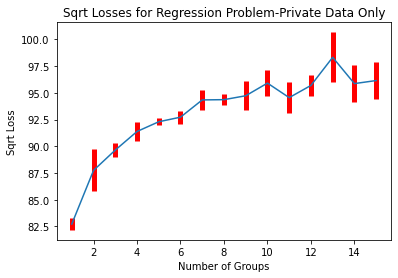

In [255]:
plt.errorbar(x=loss_dict.keys(), y = [statistics.mean(loss_list) for loss_list in loss_dict.values()], 
             yerr=[statistics.stdev(loss_list) for loss_list in loss_dict.values()],  ecolor="r",
             elinewidth=5)
plt.title("Sqrt Losses for Regression Problem-Private Data Only")
plt.xlabel("Number of Groups")
plt.ylabel("Sqrt Loss")
plt.savefig('SqrtLosses_PrivateData.png')

In [247]:
np.sqrt(results)

87.92763803975403

In [ ]:
accuracy_dict = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[], 14:[], 15:[]}
for group_number in range(1,16):
    for m in range(5):

        df_final_onehot = transform_dataset(df, group_number)

        ratios = [0.65, 0.8]

        col_num_final = len(df_final_onehot.columns)
        row_num_final = len(df_final_onehot.index)

        trainx = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 1:(col_num_final)]
        trainy = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 0]

        valx = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 1:(col_num_final)]
        valy = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 0]

        testx = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 1:(col_num_final)]
        testy = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 0]

        inp_size = len(trainx.columns)
        MICS_model = get_MICS_model(inp_size, drop_out = 0.25)
        checkpoint_filepath = 'tmp/checkpoint'
        callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
                keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                                 verbose = 2, mode = "auto", 
                                                  min_lr = 1e-6),
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_accuracy',
                mode='max',
                save_best_only=True)]


        MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
        history = MICS_model.fit(x = [trainx], y = trainy.values,  
                                 validation_data = ([valx], valy.values),
                                 epochs=300, batch_size = 32, callbacks=callback)
        training_val_accuracy = history.history["val_accuracy"]
        #best_row_index = np.argmax(training_val_accuracy)
        #best_val_accuracy = training_val_accuracy[best_row_index]
        #best_val_accuracy
        MICS_model.load_weights(checkpoint_filepath)
        results = MICS_model.evaluate(x = [testx], y = testy.values)
        accuracy_dict[group_number].append(results[1])

In [217]:
import statistics

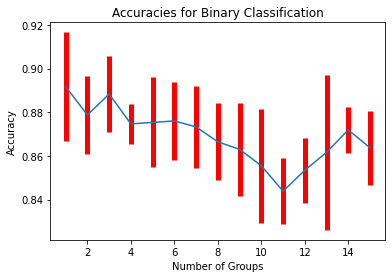

In [228]:
plt.errorbar(x=accuracy_dict.keys(), y = [statistics.mean(acc_list) for acc_list in accuracy_dict.values()], 
             yerr=[statistics.stdev(acc_list) for acc_list in accuracy_dict.values()],  ecolor="r",
             elinewidth=5)
plt.title("Accuracies for Binary Classification")
plt.xlabel("Number of Groups")
plt.ylabel("Accuracy")
plt.savefig('Binary_Accuracies.png')


In [ ]:
accuracy_dict = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[], 14:[], 15:[]}
for group_number in range(1,16):
    for m in range(5):

        df_final_onehot = transform_dataset(df, 1)

        thr_1 = 0.65/group_number
        thr_2 = thr_1*5/4

        ratios = [thr_1, thr_2]

        col_num_final = len(df_final_onehot.columns)
        row_num_final = len(df_final_onehot.index)

        trainx = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 1:(col_num_final)]
        trainy = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 0]

        valx = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 1:(col_num_final)]
        valy = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 0]

        testx = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 1:(col_num_final)]
        testy = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 0]

        inp_size = len(trainx.columns)
        MICS_model = get_MICS_model(inp_size, drop_out = 0.25)
        checkpoint_filepath = 'tmp/checkpoint'
        callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
                keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                                 verbose = 2, mode = "auto", 
                                                  min_lr = 1e-6),
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_accuracy',
                mode='max',
                save_best_only=True)]


        MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
        history = MICS_model.fit(x = [trainx], y = trainy.values,  
                                 validation_data = ([valx], valy.values),
                                 epochs=300, batch_size = 32, callbacks=callback)
        training_val_accuracy = history.history["val_accuracy"]
        #best_row_index = np.argmax(training_val_accuracy)
        #best_val_accuracy = training_val_accuracy[best_row_index]
        #best_val_accuracy
        MICS_model.load_weights(checkpoint_filepath)
        results = MICS_model.evaluate(x = [testx], y = testy.values)
        accuracy_dict[group_number].append(results[1])

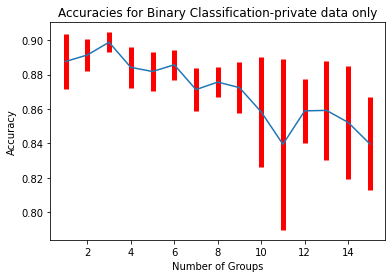

In [233]:
plt.errorbar(x=accuracy_dict.keys(), y = [statistics.mean(acc_list) for acc_list in accuracy_dict.values()], 
             yerr=[statistics.stdev(acc_list) for acc_list in accuracy_dict.values()],  ecolor="r",
             elinewidth=5)
plt.title("Accuracies for Binary Classification-private data only")
plt.xlabel("Number of Groups")
plt.ylabel("Accuracy")
plt.savefig('Binary_Accuracies_less_data.png')
